In [1]:
import sys
sys.path.append("../")
from renyi_isolation_forest.renyi_isolation_forest.pac_based_renyi_isolation_forest import PACBasedRenyiIsolationForest
from renyi_isolation_forest.renyi_isolation_forest.depth_based_renyi_isolation_forest import DepthBasedRenyiIsolationForest

## Normally distributed data with anomaly determined by 2-norm

In [2]:
import numpy as np
def generate_dataset_by_norm(d, N, contamination, random_process = np.random.randn, norm_order=2):
    data = random_process(N, d)
    anomaly = np.zeros(N, dtype=np.int8)
    norms = np.linalg.norm(data, ord=norm_order,  axis=1)
    cutoff_idx = N - round(contamination*N)
    anomaly[np.argsort(norms)[cutoff_idx:]] = 1
    return data, anomaly
data, anomaly = generate_dataset_by_norm(d=2, N=256, contamination=0.1, random_process=np.random.randn, norm_order=2)

<AxesSubplot: >

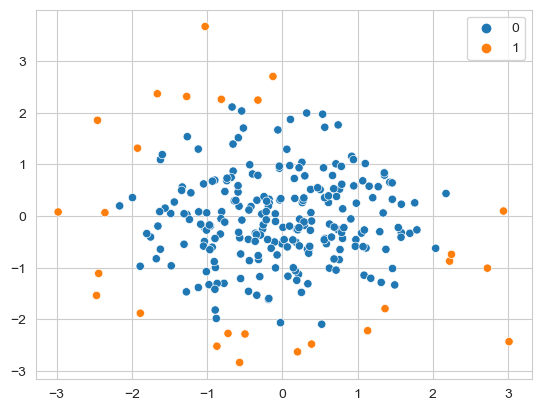

In [3]:
import seaborn as sns
sns.scatterplot(x=data[:,0], y=data[:,1] , hue=anomaly)

In [4]:
from sklearn.metrics import roc_auc_score
d_clf = DepthBasedRenyiIsolationForest()
p_clf = PACBasedRenyiIsolationForest()

d_clf.fit(data)
p_clf.fit(data)

print("AUCROC Score for Depth based:", roc_auc_score(~anomaly, d_clf.decision_function(data)))
print("AUCROC Score for PAC based:", roc_auc_score(~anomaly, p_clf.decision_function(data)))

AUCROC Score for Depth based: 0.9953177257525084
AUCROC Score for PAC based: 0.9449832775919732


In [5]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
def plot_decision_boundary(clf, data, y):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        data,
        response_method="decision_function",
    )
    disp.ax_.scatter(data[:, 0], data[:, 1], c=y, s=20, edgecolor="k")
    disp.ax_.set_title(f"decision boundary")
    plt.axis("square")
    # plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
    plt.colorbar(disp.ax_.collections[1])
    plt.show()

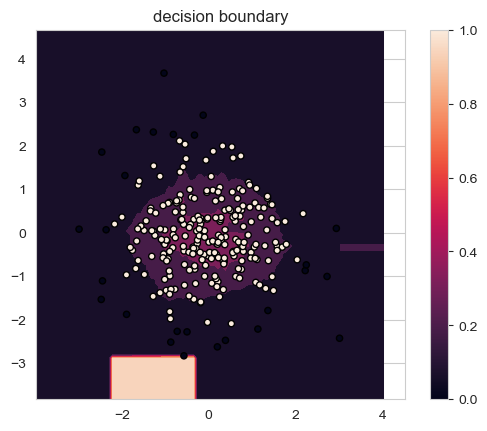

In [6]:
plot_decision_boundary(p_clf, data, ~anomaly)

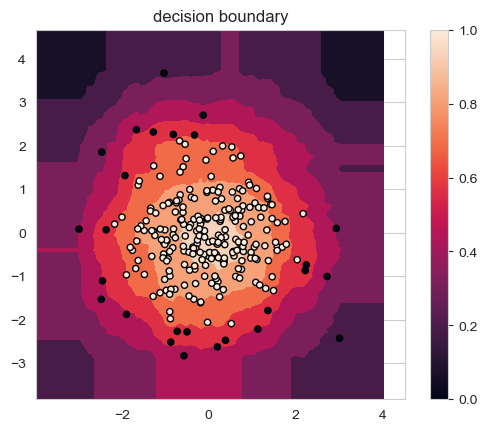

In [7]:
plot_decision_boundary(d_clf, data, ~anomaly)

## Anomalies as two separate clusters

In [8]:
N = 256
d = 2
# we make the ten percent of points that are far away from the mean an anomaly
inliers = np.random.randn(9*N//10, d)
outliers = np.random.randn(N//10, d)
maxs = np.max(inliers, axis=0)
mins = np.min(outliers, axis=0)
outliers += (maxs - mins) + 0.5
data = np.vstack([inliers, outliers])
anomaly = np.array([i < len(inliers) for i in range(len(data))])

In [9]:
d_clf = DepthBasedRenyiIsolationForest()
p_clf = PACBasedRenyiIsolationForest()

d_clf.fit(data)
p_clf.fit(data)

print("AUCROC Score for Depth based:", roc_auc_score(anomaly, d_clf.decision_function(data)))
print("AUCROC Score for PAC based:", roc_auc_score(anomaly, p_clf.decision_function(data)))

AUCROC Score for Depth based: 0.9794782608695652
AUCROC Score for PAC based: 0.964


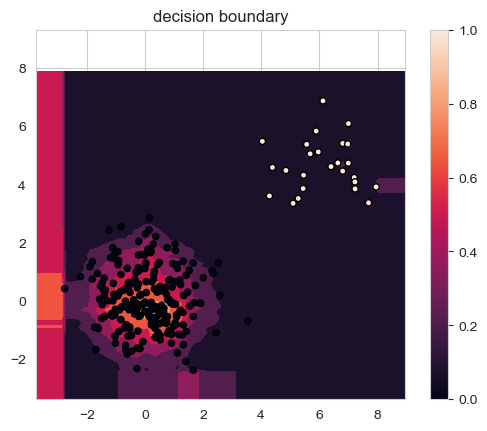

In [10]:
plot_decision_boundary(p_clf, data, ~anomaly)

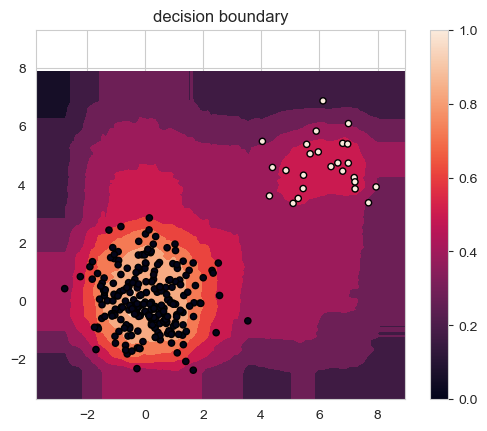

In [11]:
plot_decision_boundary(d_clf, data, ~anomaly)

## Anoamlies separeate along single axis

In [12]:
N = 256
d = 2
# we make the ten percent of points that are far away from the mean an anomaly
inliers = np.random.randn(9*N//10, d)
outliers = np.random.randn(N//10, d)
maxs = np.max(inliers, axis=0)
mins = np.min(outliers, axis=0)
maxs[1] = 0
mins[1] = 0
outliers += (maxs - mins) + 0.5
data = np.vstack([inliers, outliers])
anomaly = np.array([i < len(inliers) for i in range(len(data))])

In [13]:
d_clf = DepthBasedRenyiIsolationForest()
p_clf = PACBasedRenyiIsolationForest()

d_clf.fit(data)
p_clf.fit(data)

print("AUCROC Score for Depth based:", roc_auc_score(anomaly, d_clf.decision_function(data)))
print("AUCROC Score for PAC based:", roc_auc_score(anomaly, p_clf.decision_function(data)))

AUCROC Score for Depth based: 0.9645217391304348
AUCROC Score for PAC based: 0.9506086956521739


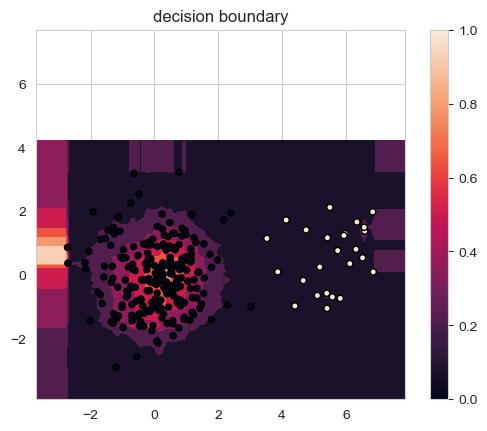

In [14]:
plot_decision_boundary(p_clf, data, ~anomaly)

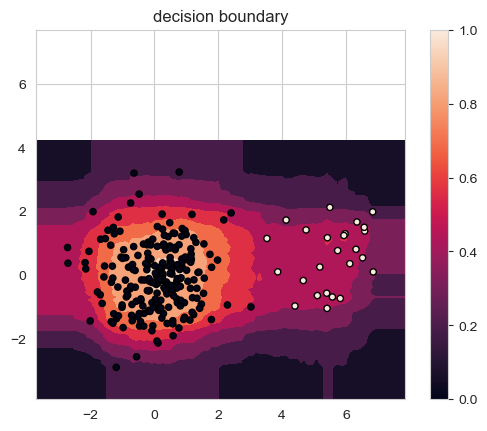

In [15]:
plot_decision_boundary(d_clf, data, ~anomaly)

### Reproduce separation as we increase d

In [16]:
def generate_dataset_outlier_along_one_axis(d, N, contamination, random_process = np.random.randn):
    outlier_count = round(contamination*N)
    inlier_count = N - outlier_count
    inliers = random_process(inlier_count, d)
    outliers = random_process(outlier_count, d)
    maxs = np.max(inliers, axis=0)
    mins = np.min(outliers, axis=0)
    shift = np.zeros(d)
    shift[0] = maxs[0] - mins[0]  + 0.2
    outliers += shift
    data = np.vstack([inliers, outliers])
    anomaly = np.array([i > inlier_count for i in range(N)])
    return data, anomaly

def evaluate_clf(cls,data, labels, alpha, **kwargs):
    clf = cls(**kwargs)
    clf.fit(data, data)
    return clf, roc_auc_score(labels, clf.decision_function(data, alpha))


In [52]:
import pandas as pd
from collections import defaultdict
def run_experiment(d_lim, data_generation_process, alpha=0, options_dict: dict = {}):
    names = ["DepthBased", "AreaBased"]
    results = pd.DataFrame(columns=names) #np.zeros((d_lim,2))
    clfs = {name: defaultdict(int) for name in names}
    for d in range (1,d_lim):
        # print(d)
        data, anomaly = data_generation_process(d)
        for clf, name, kwargs in [(DepthBasedRenyiIsolationForest, "DepthBased", {'max_depth': d**d}), (PACBasedRenyiIsolationForest, "AreaBased", {"padding":0.1, 'max_depth': d**d})]:
            # options_dict['max_depth'] = options_dict['max_depth'](d)
            # kwargs.update(options_dict)
            clfs[name][d], results.loc[d,name] = evaluate_clf(clf, data, ~anomaly, alpha, **kwargs)
    return clfs, results


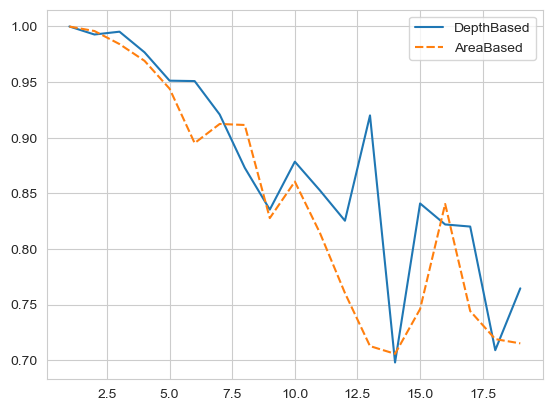

In [18]:
from functools import partial
data_generation_process = partial(generate_dataset_outlier_along_one_axis, N=25600, contamination=0.001, random_process=np.random.randn)
clfs, results = run_experiment(20, data_generation_process)
sns.lineplot(results);

## Same experiemnts but now with uniform data

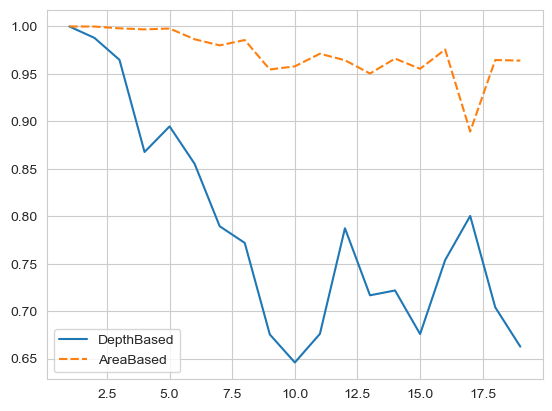

In [25]:
generate_large_uniform_dataset_with_low_contamination = partial(generate_dataset_outlier_along_one_axis, N=25600, contamination=0.001, random_process=np.random.rand)
clfs, results = run_experiment(20,generate_large_uniform_dataset_with_low_contamination)
sns.lineplot(results);

### 1-norm hypercube anomaly

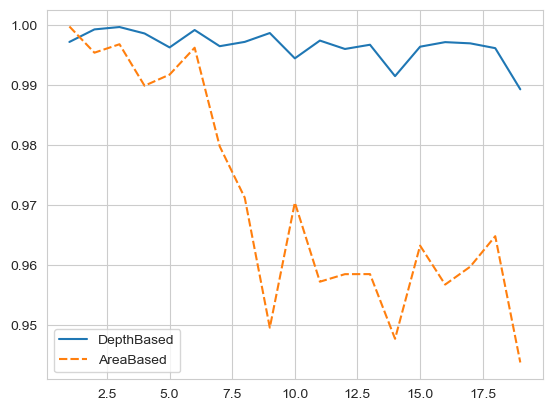

In [26]:
data_generation_process = partial(generate_dataset_by_norm, N=25600, contamination=0.001, random_process=lambda N,d: np.random.rand(N,d) - 0.5, norm_order=1)
clfs, results = run_experiment(20, data_generation_process)
sns.lineplot(results);


### Padding makes a large difference
We see above that in situations where anomalies are points that lie on the outside of the dataset, the padding makes a large difference to the performance of the PACBasedIF. This also makes sense but it's unclear how to deal with this.

### Screening and the "in the middle" experiments

In [21]:
def sample_hypersphere_points(N,d):
    aux = np.random.randn(N,d)
    lengths = np.linalg.norm(aux,ord=2, axis=1).reshape(-1,1)
    unit_coords = aux/lengths
    return unit_coords

def generate_screening_dataset(d, N, contamination, random_process, radius, sigma):
    outlier_count = round(contamination*N)
    inlier_count = N - outlier_count
    radii = np.random.randn(inlier_count) * sigma + radius*d
    inliers = radii.reshape(-1,1) * sample_hypersphere_points(inlier_count,d)
    outliers = random_process(outlier_count, d)
    data = np.vstack([inliers, outliers])
    anomaly = np.array([i >= inlier_count for i in range(N)])
    return data, anomaly

<AxesSubplot: >

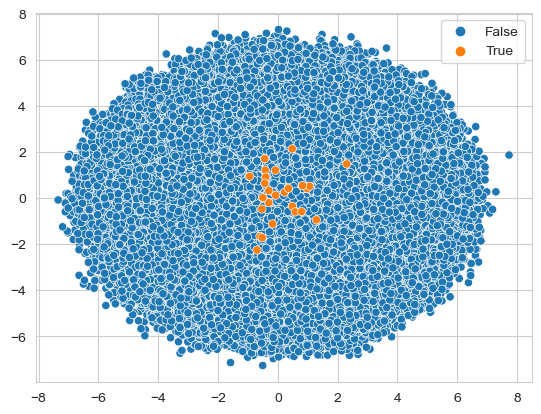

In [45]:
data, anomaly = generate_screening_dataset(3,25699,0.001,np.random.randn, 2., 0.5)
sns.scatterplot(x=data[:,2], y=data[:,1], hue=anomaly)

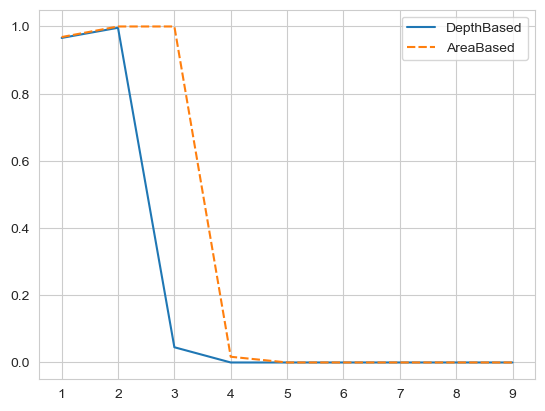

In [27]:
generate_screening = partial(generate_screening_dataset, N=25600, contamination=0.001, random_process=np.random.randn , radius=2., sigma=0.1)

clfs, results = run_experiment(10,generate_screening, 2)
sns.lineplot(results);

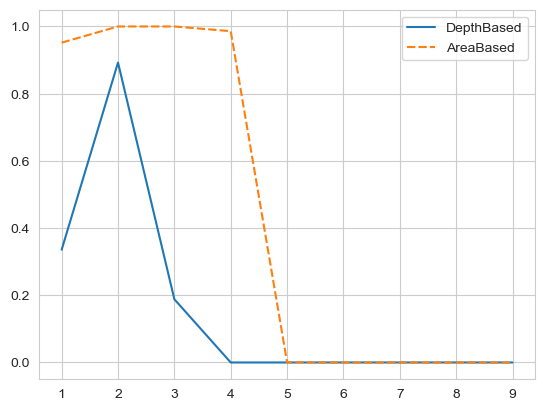

In [53]:
generate_screening = partial(generate_screening_dataset, N=25600, contamination=0.001, random_process=np.random.randn , radius=2., sigma=0.1)
calc_power = lambda d: d**d
clfs, results = run_experiment(d_lim=10,data_generation_process=generate_screening, alpha=2, options_dict={'max_depth': calc_power})
sns.lineplot(results);